# Library and dataset import section: 

In [1]:
!featurize dataset download f0d1919b-9429-4c18-a660-7291e30bfbeb

100%|██████████████████████████████████████| 2.56G/2.56G [00:11<00:00, 214MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time

# Image pre-process section:

In [3]:
# Convert an image to ela image
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [4]:
# Resize image to fixed size
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def prepare_image(image_path, image_size):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(convert_to_ela_image(image_path, 85).resize(image_size))

# Real image

In [5]:
# real images
X = [] # ELA converted images
Y = [] # label: 0 for fake, 1 for real

image_size = (32, 32) 
path = 'data/CopyAndMove/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        # if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(1)  

random.shuffle(X)
print(len(X), len(Y))

5000 5000


# Fake image

In [6]:
# fake images
path = 'data/CopyAndMove/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

10000 10000


# Shuffle and split the data

In [35]:
# Shuffle the data
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [36]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

7200 7200
2000 2000
800 800


In [37]:
# Create dataloader
BATCH_SIZE = 256

train_iterator = data.DataLoader([[X_train[i], Y_train[i]] for i in range(len(Y_train))],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader([[X_test[i], Y_test[i]] for i in range(len(Y_test))],
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader([[X_val[i], Y_val[i]] for i in range(len(Y_val))],
                                batch_size=BATCH_SIZE)

# AlexNet model

In [38]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        # Convolution layer(feature extracction)
        self.features = nn.Sequential(
            # layer 1 
            nn.Conv2d(3, 64, 3, 2, 1), 
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64), # batch normalization 
            nn.LeakyReLU(inplace=True), # leaky relu as our activation function
            # layer 2
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(inplace=True),
            # layer 3
            nn.Conv2d(192, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            # layer 4
            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            # layer 5
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
        )
        # Fully connected layer(classification)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True), 
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [51]:
# Binary classification: fake or real
OUTPUT_DIM = 2
model = AlexNet(OUTPUT_DIM)

In [52]:
# Parameter initialization
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [53]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [54]:
# Learning rate
LR = 1e-4

# Adaptive learning rate
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = 0.001, amsgrad = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [55]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Training stage

In [16]:
# Trains the model using backpropagation
# Input: torch.nn.Module, data.Dataloader, torch.optim.Optimizer, torch.nn.Module, torch.device
# Output: float, float
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
# Calculates time elapsed for the whole training
# Input: float, float
# Output: int, int
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [18]:
# Calculates the loss and accuracy of the model with the given criterion
# Input: torch.nn.Module, data.Dataloader, torch.nn.Module, torch.device
# Output: float, float
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [56]:
EPOCHS = 50
best_valid_loss = float(10000)
best_epoch = -1
start_time = time.monotonic()
end_time = -1

Train_loss = []
Val_loss = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)


    # early stopping
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'alex-copymove-model-3rd-1e-4.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    Train_loss.append(train_loss)
    Val_loss.append(valid_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.863 | Train Acc: 71.39%
	Val. Loss: 0.680 |  Val. Acc: 49.41%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.601 | Train Acc: 77.32%
	Val. Loss: 0.493 |  Val. Acc: 79.39%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.487 | Train Acc: 80.13%
	Val. Loss: 0.448 |  Val. Acc: 82.81%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.449 | Train Acc: 81.90%
	Val. Loss: 0.435 |  Val. Acc: 83.20%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.414 | Train Acc: 83.15%
	Val. Loss: 0.426 |  Val. Acc: 83.79%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.379 | Train Acc: 84.93%
	Val. Loss: 0.403 |  Val. Acc: 83.59%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.350 | Train Acc: 85.21%
	Val. Loss: 0.466 |  Val. Acc: 82.71%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.328 | Train Acc: 86.89%
	Val. Loss: 0.486 |  Val. Acc: 83.11%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.290 | Train Acc: 88.12%
	Val. Loss: 0.585 |  Val. Acc: 81.93%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.283 | Train Acc: 88.91%
	Val. Loss: 0.479 |  Val. Acc: 84.18%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.238 | Train Acc: 90.58%
	Val. Loss: 0.508 |  Val. Acc: 83.01%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.213 | Train Acc: 90.98%
	Val. Loss: 0.502 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.181 | Train Acc: 92.58%
	Val. Loss: 0.639 |  Val. Acc: 81.35%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.175 | Train Acc: 92.77%
	Val. Loss: 0.524 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.149 | Train Acc: 94.13%
	Val. Loss: 0.676 |  Val. Acc: 81.84%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.149 | Train Acc: 94.14%
	Val. Loss: 0.517 |  Val. Acc: 85.64%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.140 | Train Acc: 94.49%
	Val. Loss: 0.568 |  Val. Acc: 85.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.141 | Train Acc: 94.71%
	Val. Loss: 0.546 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.134 | Train Acc: 94.80%
	Val. Loss: 0.676 |  Val. Acc: 83.89%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.124 | Train Acc: 95.31%
	Val. Loss: 0.605 |  Val. Acc: 86.62%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21
	Train Loss: 0.100 | Train Acc: 96.05%
	Val. Loss: 0.629 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22
	Train Loss: 0.087 | Train Acc: 96.35%
	Val. Loss: 0.594 |  Val. Acc: 85.06%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23
	Train Loss: 0.100 | Train Acc: 96.32%
	Val. Loss: 0.756 |  Val. Acc: 82.81%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24
	Train Loss: 0.071 | Train Acc: 97.49%
	Val. Loss: 0.675 |  Val. Acc: 84.38%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25
	Train Loss: 0.074 | Train Acc: 97.13%
	Val. Loss: 0.715 |  Val. Acc: 84.77%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26
	Train Loss: 0.062 | Train Acc: 97.40%
	Val. Loss: 0.875 |  Val. Acc: 81.64%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27
	Train Loss: 0.068 | Train Acc: 97.44%
	Val. Loss: 0.728 |  Val. Acc: 84.28%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28
	Train Loss: 0.089 | Train Acc: 96.82%
	Val. Loss: 0.756 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29
	Train Loss: 0.078 | Train Acc: 97.23%
	Val. Loss: 0.988 |  Val. Acc: 82.52%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30
	Train Loss: 0.059 | Train Acc: 97.84%
	Val. Loss: 0.928 |  Val. Acc: 81.35%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31
	Train Loss: 0.058 | Train Acc: 97.74%
	Val. Loss: 0.822 |  Val. Acc: 83.69%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32
	Train Loss: 0.059 | Train Acc: 97.78%
	Val. Loss: 0.902 |  Val. Acc: 82.52%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33
	Train Loss: 0.065 | Train Acc: 97.80%
	Val. Loss: 0.934 |  Val. Acc: 82.71%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34
	Train Loss: 0.069 | Train Acc: 97.64%
	Val. Loss: 0.883 |  Val. Acc: 85.06%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35
	Train Loss: 0.069 | Train Acc: 97.59%
	Val. Loss: 1.039 |  Val. Acc: 83.20%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36
	Train Loss: 0.051 | Train Acc: 98.10%
	Val. Loss: 0.965 |  Val. Acc: 82.62%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37
	Train Loss: 0.038 | Train Acc: 98.55%
	Val. Loss: 0.861 |  Val. Acc: 84.86%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38
	Train Loss: 0.046 | Train Acc: 98.30%
	Val. Loss: 0.925 |  Val. Acc: 85.25%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39
	Train Loss: 0.043 | Train Acc: 98.64%
	Val. Loss: 1.040 |  Val. Acc: 84.08%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40
	Train Loss: 0.038 | Train Acc: 98.50%
	Val. Loss: 0.980 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41
	Train Loss: 0.052 | Train Acc: 98.30%
	Val. Loss: 1.018 |  Val. Acc: 85.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42
	Train Loss: 0.065 | Train Acc: 97.95%
	Val. Loss: 0.940 |  Val. Acc: 85.55%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43
	Train Loss: 0.053 | Train Acc: 98.03%
	Val. Loss: 1.127 |  Val. Acc: 83.01%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44
	Train Loss: 0.049 | Train Acc: 98.20%
	Val. Loss: 0.921 |  Val. Acc: 83.11%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 45
	Train Loss: 0.070 | Train Acc: 97.64%
	Val. Loss: 0.964 |  Val. Acc: 84.08%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 46
	Train Loss: 0.079 | Train Acc: 97.12%
	Val. Loss: 1.188 |  Val. Acc: 83.01%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 47
	Train Loss: 0.053 | Train Acc: 98.38%
	Val. Loss: 0.823 |  Val. Acc: 83.20%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 48
	Train Loss: 0.066 | Train Acc: 98.07%
	Val. Loss: 1.166 |  Val. Acc: 82.03%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 49
	Train Loss: 0.093 | Train Acc: 97.40%
	Val. Loss: 0.928 |  Val. Acc: 83.59%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50
	Train Loss: 0.053 | Train Acc: 98.18%
	Val. Loss: 0.814 |  Val. Acc: 84.47%


# First Shuffle

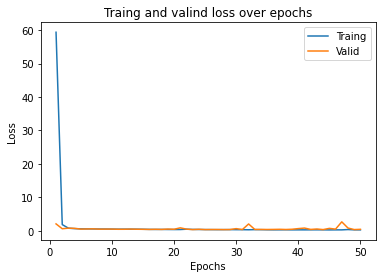

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 28
Total Time Spent: 0.0m 15s
Test Loss: 0.336 | Test Acc: 85.85%


In [82]:
# LR = 1e-2
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-1st-1e-2.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

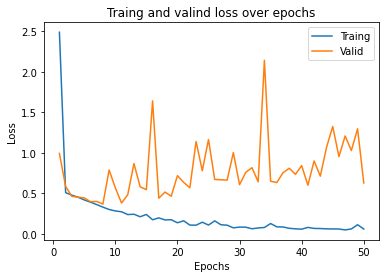

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 8
Total Time Spent: 0.0m 4s
Test Loss: 0.360 | Test Acc: 85.66%


In [92]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-1st-1e-3.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

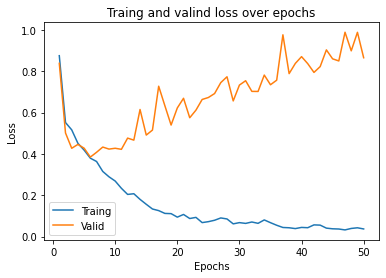

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 6
Total Time Spent: 0.0m 3s
Test Loss: 0.405 | Test Acc: 83.74%


In [102]:
# LR = 1e-4
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-1st-1e-4.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Second Shuffle

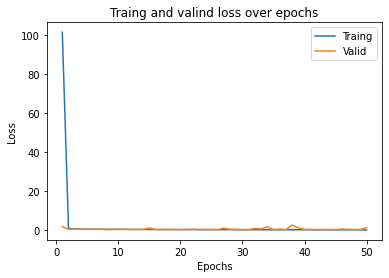

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 42
Total Time Spent: 0.0m 19s
Test Loss: 0.336 | Test Acc: 85.85%


In [20]:
# LR = 1e-2
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-2nd-1e-2.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

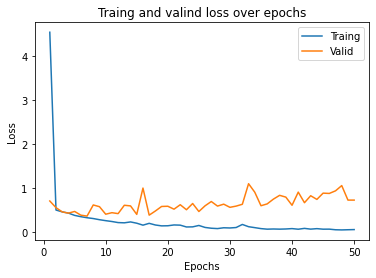

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 7
Total Time Spent: 0.0m 3s
Test Loss: 0.353 | Test Acc: 85.83%


In [27]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-2nd-1e-3.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

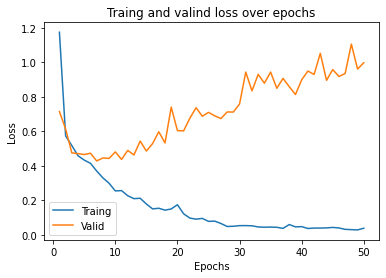

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 7
Total Time Spent: 0.0m 4s
Test Loss: 0.403 | Test Acc: 83.82%


In [34]:
# LR = 1e-4
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-2nd-1e-4.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Third Shuffle

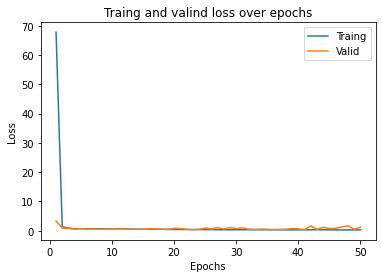

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 41
Total Time Spent: 0.0m 18s
Test Loss: 0.352 | Test Acc: 86.38%


In [44]:
# LR = 1e-2
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-3rd-1e-2.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

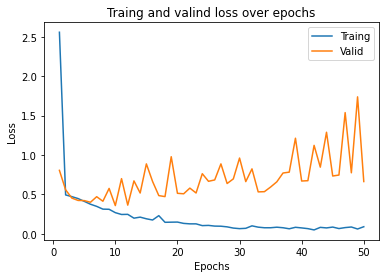

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 10
Total Time Spent: 0.0m 5s
Test Loss: 0.378 | Test Acc: 86.35%


In [50]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-3rd-1e-3.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

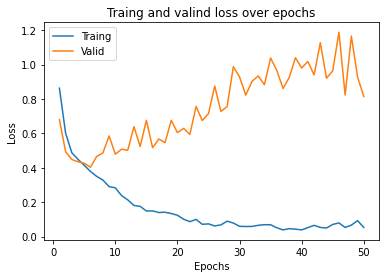

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 6
Total Time Spent: 0.0m 3s
Test Loss: 0.431 | Test Acc: 82.80%


In [58]:
# LR = 1e-4
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('alex-copymove-model-3rd-1e-4.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')